In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.67 MiB | 18.49 MiB/s, done.
Resolving deltas: 100% (11704/11704), done.
/content/yolov5


In [ ]:

# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 15.9 MB/s eta 0:00:00
Setup complete. Using torch 2.5.0+cu121 CPU


In [ ]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="o1nBbIMZL7MDlVwUUMqI")
project = rf.workspace("project-xhnot").project("fire-or-smoke-detection-d0jio")
version = project.version(4)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fire-or-smoke-detection-4 in yolov5pytorch:: 100%|██████████| 5052/5052 [00:01<00:00, 4396.42it/s]


In [ ]:

%pwd

'/content/yolov5'

In [ ]:

dataset.location

'/content/yolov5/fire-or-smoke-detection-4'

In [ ]:

%cd /content/yolov5

/content/yolov5


In [ ]:

dataset.location

'/content/yolov5/fire-or-smoke-detection-4'

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- fire
- smoke
nc: 2
roboflow:
  license: CC BY 4.0
  project: fire-or-smoke-detection-d0jio
  url: https://universe.roboflow.com/project-xhnot/fire-or-smoke-detection-d0jio/dataset/4
  version: 4
  workspace: project-xhnot
test: ../test/images
train: fire-or-smoke-detection-4/train/images
val: fire-or-smoke-detection-4/valid/images


**Model Configuration and Architecture**

In [ ]:

# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:

num_classes

'2'

In [ ]:
#Basically we are trying to view the architecture of the model that we are baout to use

%cat /content/yolov5/models/yolov5s.yaml

# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4],

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
# Ultralytics YOLOv5 🚀, AGPL-3.0 license
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml
# Parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]

**Training**

**Parameters**

**img**: define input image size

**batch**: determine batch size

**epochs**: define the number of training epochs.
(Note: often, 3000+ are common here!)

**data**: set the path to our yaml file

**cfg**: specify our model configuration

**weights**: specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive folder)

**name**: result names

**nosave**: only save the final checkpoint

**cache**: cache images for faster training

In [ ]:

# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 1 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results  --cache

/content/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-13 15:17:20.846542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 15:17:20.897033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 15:17:20.911964: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452

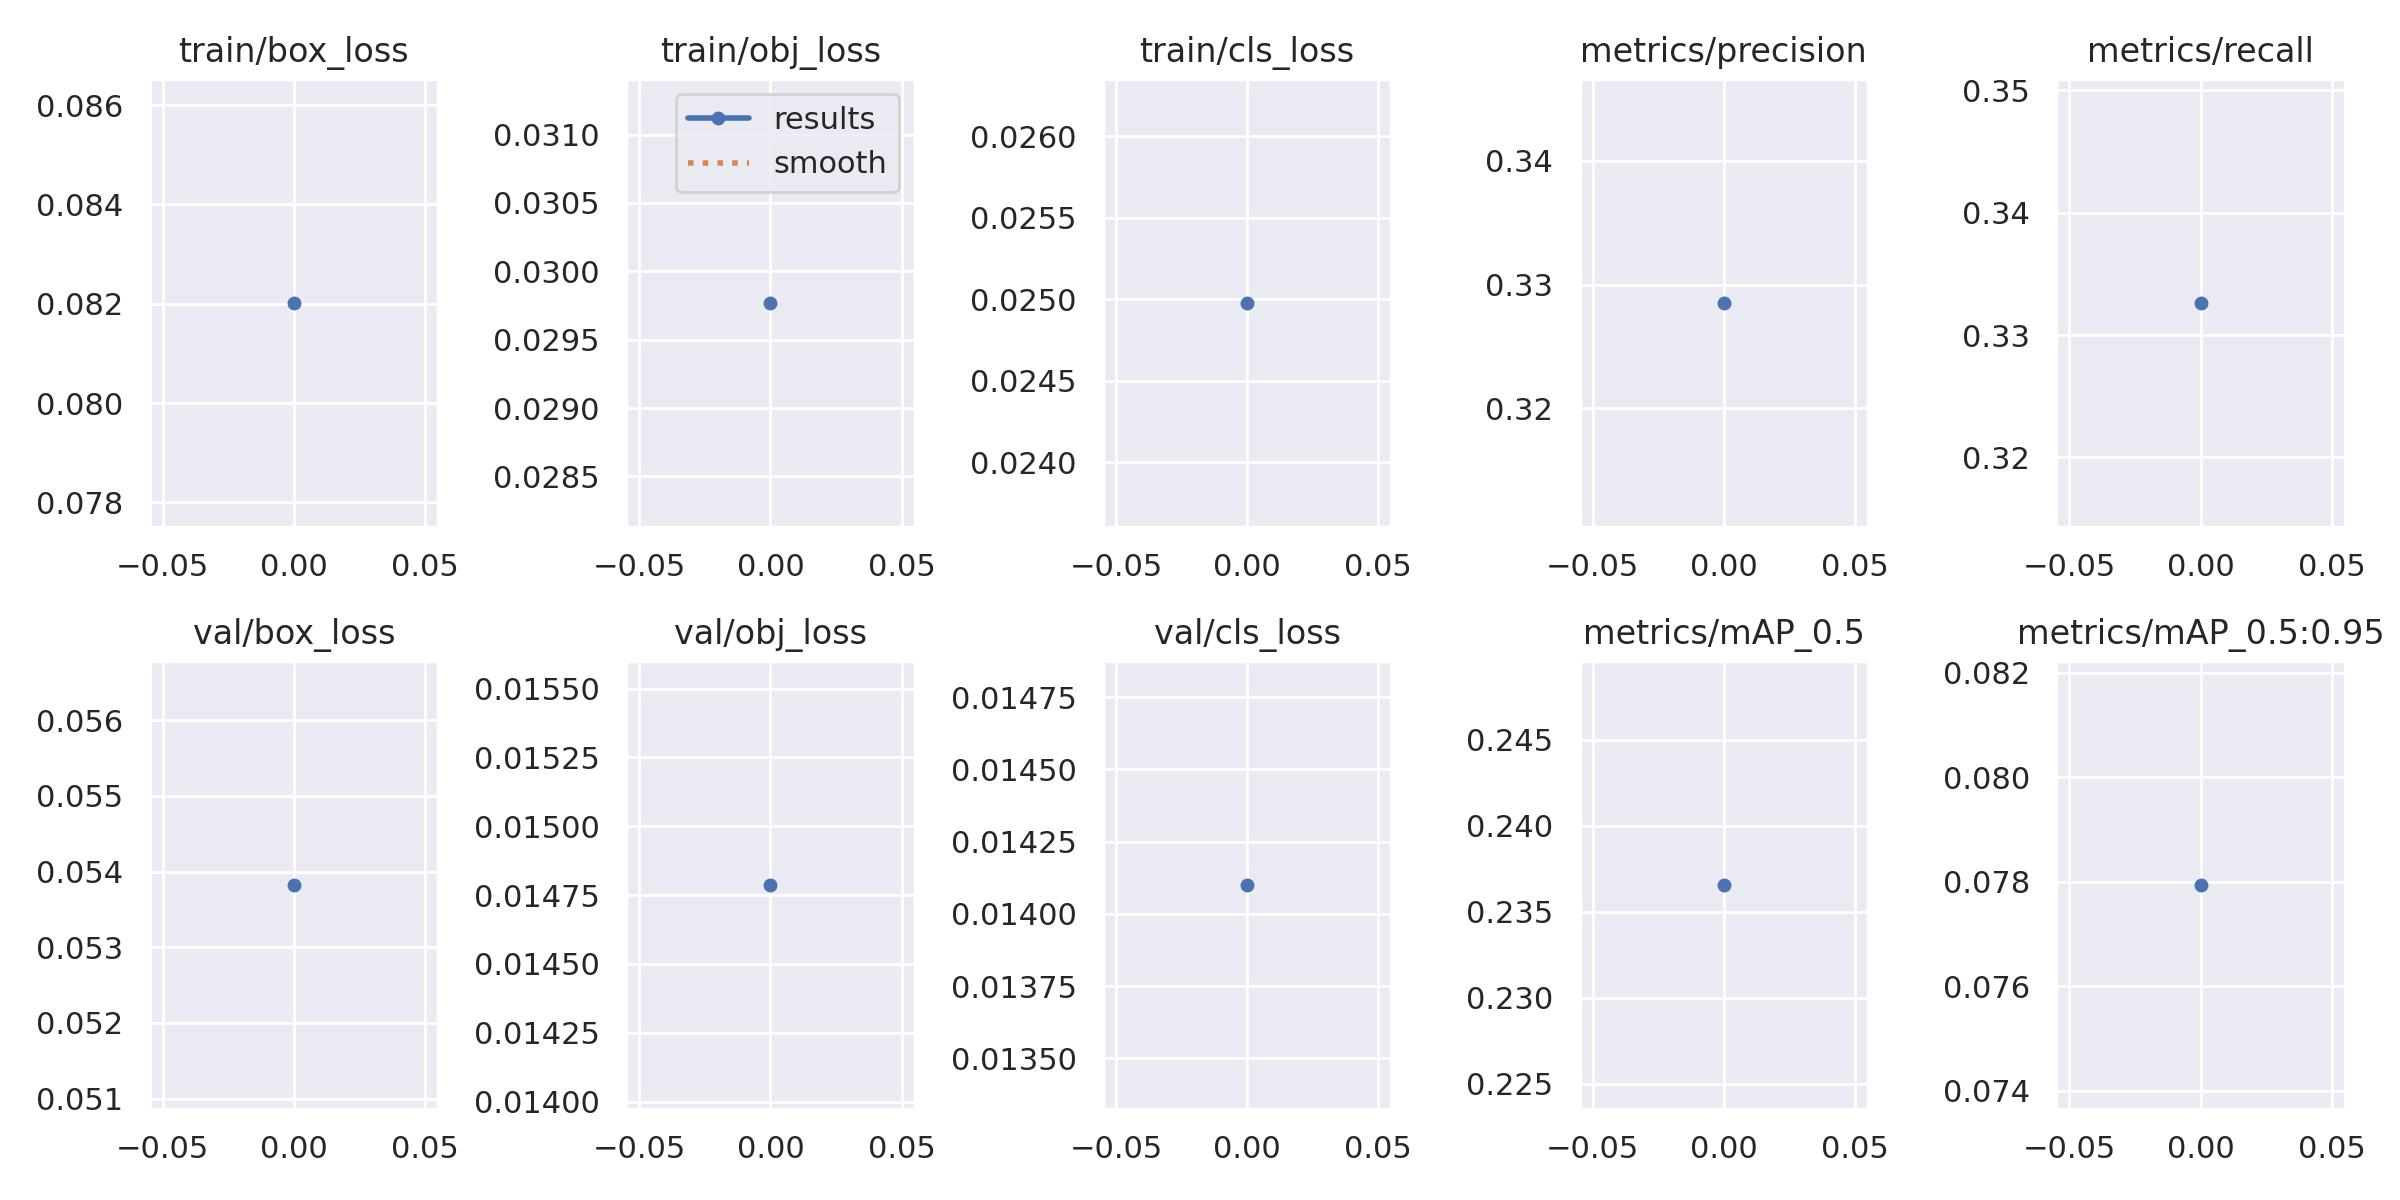

In [ ]:

from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

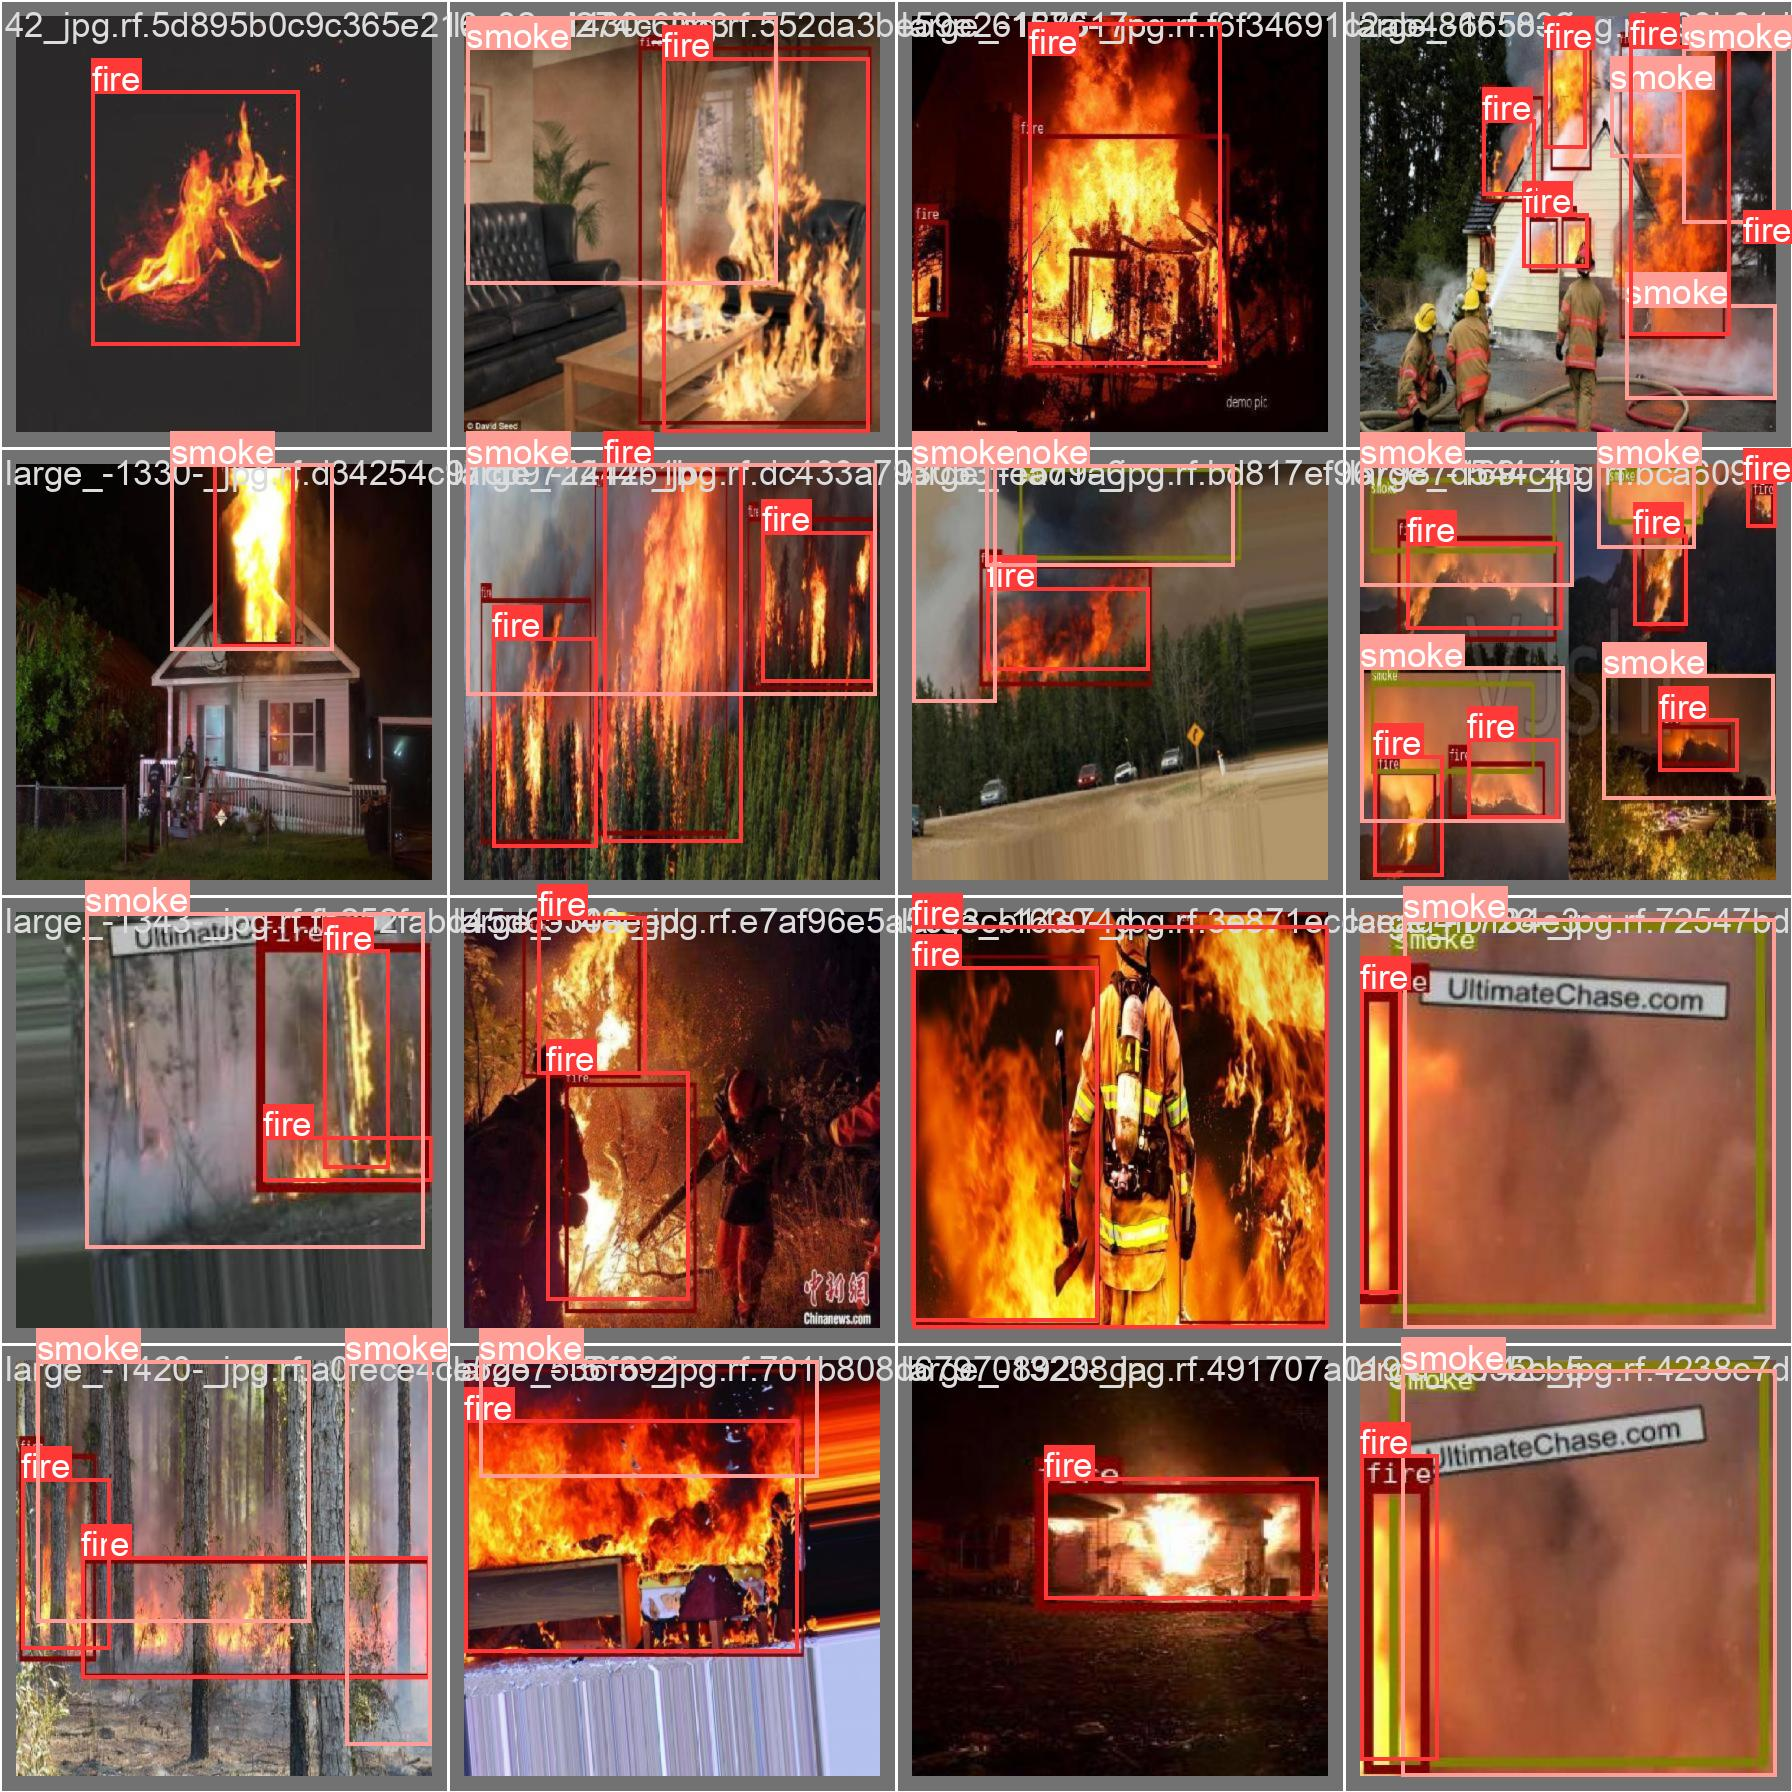

In [ ]:

Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [ ]:

%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source /content/yolov5/fire-or-smoke-detection-4/test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/content/yolov5/fire-or-smoke-detection-4/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.10.12 torch-2.5.0+cu121 CPU

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/105 /content/yolov5/fire-or-smoke-detection-4/test/images/0055_jpg.rf.e86b611eb4471609ab9667c9a04b9b6a.jpg: 416x416 (no detections), 232.3ms
image 2/105 /content/yolov5/fire-or-smoke-detection-4/test/images/H_02189_png_jpg.rf.a9b6c77b7222a0799eca1335233fdea1.j